# Lab 02 - Weather

---
embed-resources: true
---

## Introduction

The purpose of this report is determine when the Urbana Farmers Market (Market at the Square) should transition to an indoor market as the weather gets colder. Weather data was collected using the Open-Meteo API, specifically, the [Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api/). A k-nearest neighbors regression model will be used.

## Methods

In [1]:
# imports
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
from joblib import dump
import matplotlib.pyplot as plt

### Data

In [2]:
# load data
weather_train = pd.read_parquet(
    "https://cs307.org/lab/data/weather-train.parquet",
)
weather_vtrain = pd.read_parquet(
    "https://cs307.org/lab/data/weather-vtrain.parquet",
)
weather_validation = pd.read_parquet(
    "https://cs307.org/lab/data/weather-validation.parquet",
)
weather_test = pd.read_parquet(
    "https://cs307.org/lab/data/weather-test.parquet",
)

The data contains one row per day for the years 2016 to 2024. The data is split by time: Train: 2016 - 2022, Validation-Train: 2016 - 2020, Validation: 2021 - 2022, Test: 2023, and Production: 2024. The variables considered are:

#### Response

**`temperature_2m_min`**

- [float64] the minimum air temperature at 2 meters above ground for the day

#### Features

**`year`**

- [int64] year , such as 2020

**`day`**

- [int64] day of the month, for example 20 for January 20

**`day_of_year`**

- [int64] day of the year, for example 100, which in non-leap years in is April 9

In [3]:
weather_train.groupby('year').agg('count')

,temperature_2m_min,month,day,day_of_year
year,,,,
2016,366,366,366,366
2017,365,365,365,365
2018,365,365,365,365
2019,365,365,365,365
2020,366,366,366,366
2021,365,365,365,365
2022,365,365,365,365


Every year has an 365 observations, or 366 for leap years.

In [4]:
weather_train.groupby('year').agg('mean')

,temperature_2m_min,month,day,day_of_year
year,,,,
2016,8.793390,6.513661,15.756831,183.5
2017,8.399644,6.526027,15.720548,183.0
2018,7.591013,6.526027,15.720548,183.0
2019,7.229781,6.526027,15.720548,183.0
2020,7.684612,6.513661,15.756831,183.5
2021,8.119370,6.526027,15.720548,183.0
2022,7.010192,6.526027,15.720548,183.0


We see that the mean minimum temperature varies from year to year.

In [5]:
weather_train.groupby('year').agg('std')

,temperature_2m_min,month,day,day_of_year
year,,,,
2016,10.274506,3.455958,8.823592,105.799338
2017,9.692305,3.452584,8.808321,105.510663
2018,11.369452,3.452584,8.808321,105.510663
2019,10.882259,3.452584,8.808321,105.510663
2020,9.383594,3.455958,8.823592,105.799338
2021,10.388490,3.452584,8.808321,105.510663
2022,11.028170,3.452584,8.808321,105.510663


We see that the standard deviation of the minimum temperature varies from year to year.

In [6]:
weather_train.groupby('month').agg('mean')

,temperature_2m_min,year,day,day_of_year
month,,,,
1,-5.416767,2019.000000,16.000000,16.000000
2,-4.380614,2018.989899,14.646465,45.646465
3,1.522173,2019.000000,16.000000,75.285714
4,5.925214,2019.000000,15.500000,105.785714
5,12.639454,2019.000000,16.000000,136.285714
6,18.211405,2019.000000,15.500000,166.785714
7,19.998209,2019.000000,16.000000,197.285714
8,19.088070,2019.000000,16.000000,228.285714
9,16.571642,2019.000000,15.500000,258.785714


We see that the mean minimum temperature varies from month to month.

In [7]:
weather_train.groupby('month').agg('std')

,temperature_2m_min,year,day,day_of_year
month,,,,
1,6.547430,2.004624,8.964952,8.964952
2,6.746121,2.007574,8.187291,8.187291
3,5.595675,2.004624,8.964952,8.976380
4,5.659612,2.004779,8.676124,8.687933
5,5.234890,2.004624,8.964952,8.976380
6,3.540279,2.004779,8.676124,8.687933
7,2.627939,2.004624,8.964952,8.976380
8,2.874603,2.004624,8.964952,8.976380
9,3.988397,2.004779,8.676124,8.687933


We see that the standard deviation of the minimum temperature varies from month to month. Winter months seem to have a higher standard deviation in temperature than summer months. This is unfortunate for our purposes since we are interested in predicting temperatures in the colder months.

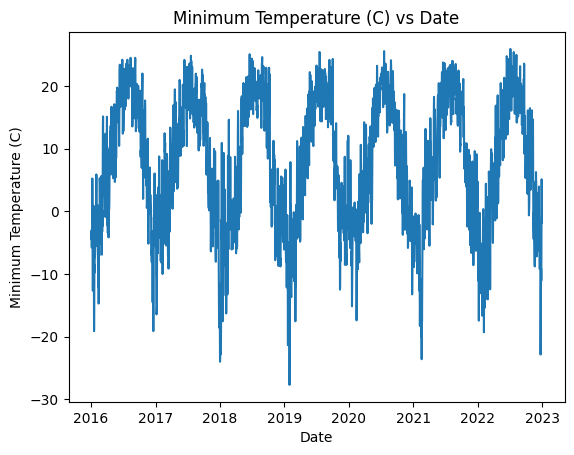

In [8]:
# exploratory visualization
plt.plot(weather_train.index, weather_train['temperature_2m_min'])
plt.title("Minimum Temperature (C) vs Date")
plt.xlabel("Date")
plt.ylabel("Minimum Temperature (C)")
plt.show()

This plot shows how the minumim temperature varies over time. There is a seasonal pattern, as expected.

### Models

In [9]:
# process data for ML
# create X and y for train
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]

In [10]:
# train models
# Pick Estimator -> KNN
# Specify Params to Try
k_values = [1,5,10,25,100,250]
val_rmses = []

# test each k value
for k in k_values:
    # instantiate estimator
    knn = KNeighborsRegressor(n_neighbors=k, p=1)

    # fit estimator
    _ = knn.fit(X_vtrain, y_vtrain)

    # get validation predictions
    y_pred_val = knn.predict(X_validation)

    # get validation rmse
    val_rmse = root_mean_squared_error(y_validation, y_pred_val)
    print(f"Validation RMSE when k={k}: {val_rmse}")
    val_rmses.append(val_rmse)

Validation RMSE when k=1: 6.285232067108154
Validation RMSE when k=5: 5.397881031036377
Validation RMSE when k=10: 5.098583698272705
Validation RMSE when k=25: 5.024857044219971
Validation RMSE when k=100: 4.974940299987793
Validation RMSE when k=250: 4.993910789489746


We consider 6 different models, using different numbers of nearest neighbors. Using k=100 yields the lowest root mean square error for the validation data, so we will select this model.

In [11]:
# select k=100 based on validation performace
knn = KNeighborsRegressor(n_neighbors=100, p=1)
_ = knn.fit(X_train, y_train)

## Results

In [12]:
# report model metrics
# evaluate test data
y_pred_test = knn.predict(X_test)
root_mean_squared_error(y_test, y_pred_test)

4.725839138031006

The selected model achieves a test root mean square error of 4.7258 degrees Celsius.

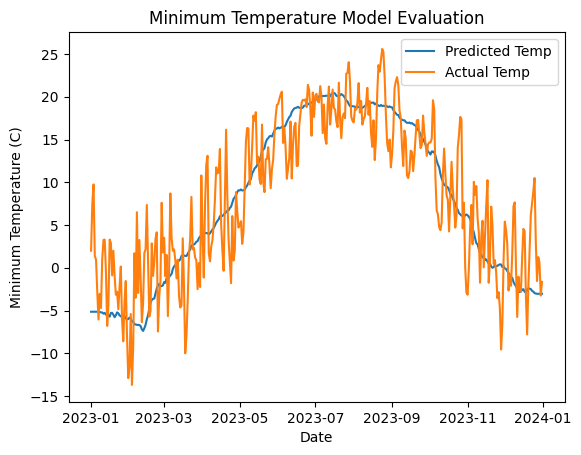

In [13]:
# summary figure
plt.plot(X_test.index, y_pred_test, label='Predicted Temp')
plt.plot(X_test.index, y_test, label='Actual Temp')
plt.legend()
plt.title("Minimum Temperature Model Evaluation")
plt.xlabel("Date")
plt.ylabel("Minimum Temperature (C)")
plt.show()

This plot shows the predictions for our test data features vs the actual test data target. We see that the general shape is followed, but there is still lots of uncertainty.

In [14]:
# serialize model
dump(knn, 'weather.joblib')

['weather.joblib']

## Discussion

I would reccomend against putting this model into practice. This model provides little advantage over using historical averages, with an RMSE of 4.7 degrees Celsius (8.5 degrees Fahrenheit). In the summary statistics, we saw that in November and December the standard deviation in temperature is around 5.7 degrees Celsius (10.3 degrees Fahrenheit), showing that this model may be slightly better at predicting the temperature, on average. However, it is still not very close. For the purpose of deciding when to move the Urbana Farmers Market indoors as freezing temperatures arrive, an error of 8.5 degrees is the different between 30 degree Fahrenheit weather (below freezing), and 38 degree Fahrenheit weather (quite tolerable). Furthermore, this model provides absolutely zero advantages over using a 10-day weather forecast, which is far more accurate on account of more sophisticated models and available data. Putting this model into practice risks moving the market indoors too early, when a normal weather forecast might suggest otherwise. It would be impractical to advise improvements to this model in order to make it more fit for use, seeing as more sophisticated weather models already exist and are freely available.